# ME 454 Homework 5
## By: Christopher Tsai

In [68]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from scipy import integrate

Problem 1:

In [69]:
N = 1000

def x_ode(t, x):
    x1, x2 = x
    x1dot = -x1
    x2dot = x1 + 2*x2
    return x1dot, x2dot

x_sol = integrate.solve_ivp(x_ode, [0, 0.5], [1, 1], t_eval=np.linspace(0, 0.5, N))
x1 = x_sol.y[0]
x2 = x_sol.y[1]

print("x(0.5) =", [x1[-1], x2[-1]])

def phi_ode(t, phi):
    phi11, phi12, phi21, phi22 = phi
    phi11dot = -phi11
    phi12dot = -phi12
    phi21dot = phi11 + 2*phi21
    phi22dot = phi12 + 2*phi22
    return phi11dot, phi12dot, phi21dot, phi22dot

phi_sol = integrate.solve_ivp(phi_ode, [0, 0.5], [1, 0, 0, 1], t_eval=np.linspace(0, 0.5, N))
phi11 = phi_sol.y[0]
phi12 = phi_sol.y[1] 
phi21 = phi_sol.y[2]
phi22 = phi_sol.y[3]

phi_x0 = np.matmul(np.array([[phi11[-1], phi12[-1]], [phi21[-1], phi22[-1]]]), np.array([[1], [1]]))

print("phi(0.5, 0)*x0 =", [phi_x0[0][0], phi_x0[1][0]])

x(0.5) = [0.6065325441516192, 3.422249649989296]
phi(0.5, 0)*x0 = [0.6065311404648684, 3.42222362787434]


Problem 2:

In [70]:
def p_ode(p, t):
    p1, p2 = p
    p1dot = -p1
    p2dot = p1 + 2*p2
    return p1dot, p2dot

p_sol = integrate.odeint(p_ode, [1, 1], np.linspace(0.5, 0, N))

print("p(0) =", [p_sol[-1][0], p_sol[-1][1]])

phi_pT = np.matmul(np.linalg.inv(np.array([[phi11[-1], phi12[-1]], [phi21[-1], phi22[-1]]])), np.array([[1], [1]]))

print("phi(0.5, 0)*pT =", [phi_pT[0][0], phi_pT[1][0]])

p(0) = [1.64872127351165, -0.059067817096146356]
phi(0.5, 0)*pT = [1.6487199638810996, -0.05907077001964395]


Problem 3:

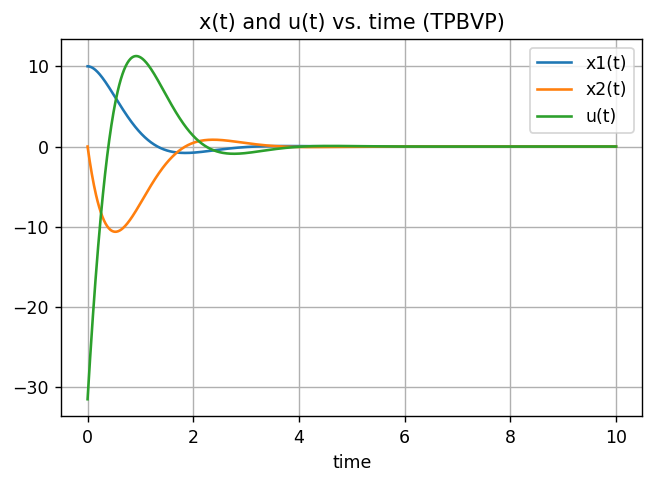

In [71]:
Q = np.array([[2, 0], [0, 0.1]])
R = np.array([[0.1]])
P1 = np.array([[1, 0], [0, 0.01]])   # P1 = P(T)
A = np.array([[0, 1], [-1.6, -0.4]])
B = np.array([[0], [1]])
x0 = np.array([[10], [0]])

def x_bar_ode(t, r):    
    x1 = r[0, :]
    x2 = r[1, :]
    p1 = r[2, :]
    p2 = r[3, :]
    
    mat_top = np.concatenate((A, (-B@np.linalg.inv(R)@B.T)), axis=1)
    mat_bot = np.concatenate((-Q, -A.T), axis=1)
    mat = np.concatenate((mat_top, mat_bot), axis=0)
    x1dot = (mat@np.vstack([x1,x2,p1,p2]))[0]
    x2dot = (mat@np.vstack([x1,x2,p1,p2]))[1]
    p1dot = (mat@np.vstack([x1,x2,p1,p2]))[2]
    p2dot = (mat@np.vstack([x1,x2,p1,p2]))[3]
    
    return np.vstack([x1dot, x2dot, p1dot, p2dot])

def bc(ya, yb):
    pT = np.dot(yb[0:2], P1).flatten()  # p(T) = p1 = P1*x(T), turns out this is equal to [[0], [0]]
    return np.array([ya[0] - x0[0], ya[1] - x0[1], yb[2] - pT[0], yb[3] - pT[1]]).flatten()

T = 10

initial_guess = np.zeros((4, N))

x_bar_sol = integrate.solve_bvp(x_bar_ode, bc, np.linspace(0, T, N), initial_guess)

u = -np.linalg.inv(R)@B.T@x_bar_sol.y[2:4]

plt.figure(dpi=125, facecolor='w')
plt.plot(np.linspace(0, T, N), x_bar_sol.y[0], label='x1(t)')
plt.plot(np.linspace(0, T, N), x_bar_sol.y[1], label='x2(t)')
plt.plot(np.linspace(0, T, N), u[0], label='u(t)')
plt.legend()
plt.xlabel('time')
plt.grid(True)
plt.title("x(t) and u(t) vs. time (TPBVP)")
plt.show()

Problem 4:

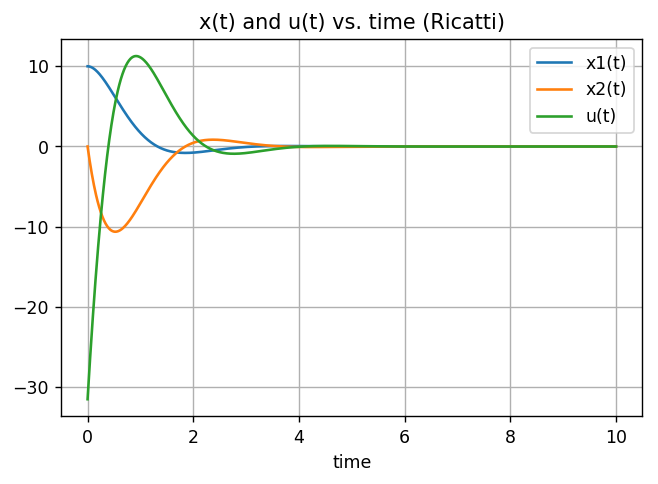

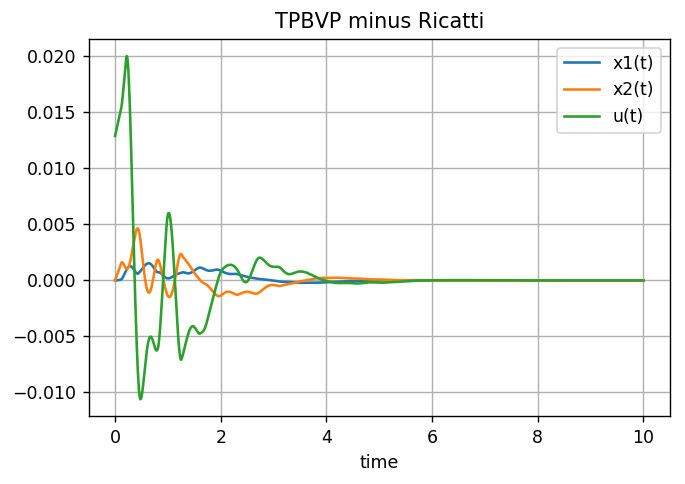

In [72]:
def P_ode(t, P):
    P = np.array([[P[0], P[1]], [P[2], P[3]]])    # P[0] = P11, P[1] = P12, P[2] = P21, P[3] = P22
    Pdot = -P@A - A.T@P + P@B@np.linalg.inv(R)@B.T@P - Q
    P11dot = Pdot[0, 0]
    P12dot = Pdot[0, 1]
    P21dot = Pdot[1, 0]
    P22dot = Pdot[1, 1]
    return P11dot, P12dot, P21dot, P22dot

P_sol = integrate.solve_ivp(P_ode, [T, 0], [P1[0, 0], P1[0, 1], P1[1, 0], P1[1, 1]], t_eval=np.linspace(T, 0, N))
P11 = np.flip(P_sol.y, 1)[0]
P12 = np.flip(P_sol.y, 1)[1]
P21 = np.flip(P_sol.y, 1)[2]
P22 = np.flip(P_sol.y, 1)[3]

def x_ode(t, x):
    x = np.array([[x[0]], [x[1]]])
    P_i = np.array([[P11[int(t*(N-1)/T)], P12[int(t*(N-1)/T)]], [P21[int(t*(N-1)/T)], P22[int(t*(N-1)/T)]]])
    xdot = (A - B@np.linalg.inv(R)@B.T@P_i)@x
    x1dot = xdot[0, 0]
    x2dot = xdot[1, 0]
    return x1dot, x2dot

x_sol_ric = integrate.solve_ivp(x_ode, [0, T], [x0[0, 0], x0[1, 0]], t_eval=np.linspace(0, T, N))

u_ric = np.zeros(N)

for i in range(N):
    P_i = np.array([[P11[i], P12[i]], [P21[i], P22[i]]])
    x_i = np.array([[x_sol_ric.y[0][i]], [x_sol_ric.y[1][i]]])
    p_vec = P_i@x_i
    u_ric[i] = -np.linalg.inv(R)@B.T@p_vec

plt.figure(dpi=125, facecolor='w')
plt.plot(np.linspace(0, T, N), x_sol_ric.y[0], label='x1(t)')
plt.plot(np.linspace(0, T, N), x_sol_ric.y[1], label='x2(t)')
plt.plot(np.linspace(0, T, N), u_ric, label='u(t)')
plt.legend()
plt.xlabel('time')
plt.grid(True)
plt.title("x(t) and u(t) vs. time (Ricatti)")
plt.show()

plt.figure(dpi=125, facecolor='w')
plt.plot(np.linspace(0, T, N), x_bar_sol.y[0] - x_sol_ric.y[0], label='x1(t)')
plt.plot(np.linspace(0, T, N), x_bar_sol.y[1] - x_sol_ric.y[1], label='x2(t)')
plt.plot(np.linspace(0, T, N), u[0] - u_ric, label='u(t)')
plt.legend()
plt.xlabel('time')
plt.grid(True)
plt.title("TPBVP minus Ricatti")
plt.show()